In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Help Functions

In [17]:
# Functions that will help cleaning the dataset
def get_winner(df, cat=False):
    """
    Get the winner from the dataset based on goals
    """
    if df['home_team_score'] > df['away_team_score']:
        return df['home_team'] if not cat else 1
    return df['away_team'] if not cat else 0

def clean_stage(df):
    """
    Remove the groups x and replace it just with Groups
    """
    if df['Stage'].__contains__('Group'):
        return 'Group'
    return df['Stage']

def mix_fifa_data(df, fifa_data):
    """
    Add fifa data
    """
    df.reset_index(drop=True, inplace=True)
    for i in range(df.shape[0]):
        try:
            df['home_overall'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['Overall'].values[0].astype(np.float64)
            df['away_overall'][i] = fifa_data[fifa_data['Nationality'] == df['away_team'][i]]['Overall'].values[0].astype(np.float64)
            df['home_potential'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['Potential'].values[0].astype(np.float64)
            df['away_potential'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['Potential'].values[0].astype(np.float64)
            df['home_reputation'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['International Reputation'].values[0].astype(np.float64)
            df['away_reputation'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['International Reputation'].values[0].astype(np.float64)
        except:
            df['home_overall'][i] = 0
            df['away_overall'][i] = 0
            df['home_potential'][i] = 0
            df['away_potential'][i] = 0
            df['home_reputation'][i]= 0
            df['away_reputation'][i]= 0

def get_prediction_df(home_team, away_team):
    """
    Get the prediction df frame from a home_team and away_team
    """
    columns = ['team_fifa_rank', 'team_total_fifa_points', 'overall', 'potential']
    data_dict = {}
    for column in columns:
        data_dict['home_' + column] = country_gb['home_' + column][home_team]
        data_dict['away_' + column] = country_gb['away_' + column][away_team]

    predict_df = pd.DataFrame([data_dict])

    predict_df['overall_difference'] = predict_df['home_overall'] - predict_df['away_overall']
    predict_df['potential_difference'] = predict_df['home_potential'] - predict_df['away_potential']
    predict_df['rank_difference'] = predict_df['home_team_fifa_rank'] - predict_df['away_team_fifa_rank']
    predict_df['average_rank'] = (predict_df['home_team_fifa_rank'] + predict_df['away_team_fifa_rank'])/2
    predict_df['point_difference'] = predict_df['home_team_total_fifa_points'] - predict_df['away_team_total_fifa_points']

    predict_df.drop(['home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_overall', 'away_overall','home_potential', 'away_potential',
       ], axis=1, inplace=True)
    
    return predict_df

## Start

In [18]:
# Datos desde el local
international_matches = pd.read_csv("files/international_matches.csv")
data_fifa_23 = pd.read_csv('files/FIFA23_official_data.csv')

In [19]:
#List of all Teams in 2022 World Cup
teams_worldcup = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'Iran', 'USA',
                  'Wales', 'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 
                  'Australia', 'Denmark', 'Tunisia', 'Spain', 'Costa Rica', 'Germany', 
                  'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia', 'Brazil', 'Serbia', 
                  'Switzerland', 'Cameroon', 'Portugal', 'Ghana', 'Uruguay', 'Korea Republic']

## Players Data

In [20]:
# Elimino Columnas a ojo
data_fifa_23.drop(['ID', 'Photo', 'Flag', 'Club', 'Club Logo', 'Release Clause', 'Kit Number', 'Contract Valid Until',
                   'Real Face', 'Body Type', 'Work Rate', 'Position', 'Loaned From', 'Name', 'Preferred Foot', 'Wage', 'Weak Foot', 'Age'], axis=1, inplace=True)

In [21]:
data_fifa_23.replace({'United States': 'USA'}, inplace=True)

In [22]:
data_fifa_grouped = data_fifa_23.groupby(['Nationality']).mean()

/var/folders/_9/3yvdrh7x2wn7kr898n5fm8z40000gn/T/ipykernel_4291/3576440808.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_fifa_grouped = data_fifa_23.groupby(['Nationality']).mean()


In [23]:
data_fifa_grouped.reset_index(inplace=True)

In [24]:
data_fifa_grouped = data_fifa_grouped.reset_index(level=0)

## Matches International

In [25]:
# Turn date into a datetime object
international_matches['date'] = pd.to_datetime(international_matches['date'])
international_matches['home_overall'] = np.float64(0)
international_matches['away_overall'] = np.float64(0)
international_matches['home_potential'] = np.float64(0)
international_matches['away_potential'] = np.float64(0)
international_matches['home_reputation'] = np.float64(0)
international_matches['away_reputation'] = np.float64(0)

In [26]:
international_matches = international_matches.loc[(international_matches['home_team'].isin(teams_worldcup) | international_matches['away_team'].isin(teams_worldcup)) & (international_matches['date'] > '2010-01-01')]
international_matches['Won'] = international_matches.apply(lambda row: get_winner(row, cat=True), axis=1)
mix_fifa_data(international_matches, data_fifa_grouped)
international_matches.drop(['home_team_continent', 'date', 'away_team_continent', 'shoot_out', 'home_team_result', 'tournament', 'city', 'neutral_location', 'country'], inplace=True, axis=1)

/var/folders/_9/3yvdrh7x2wn7kr898n5fm8z40000gn/T/ipykernel_4291/3554268434.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home_overall'][i] = fifa_data[fifa_data['Nationality'] == df['home_team'][i]]['Overall'].values[0].astype(np.float64)
/var/folders/_9/3yvdrh7x2wn7kr898n5fm8z40000gn/T/ipykernel_4291/3554268434.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['away_overall'][i] = fifa_data[fifa_data['Nationality'] == df['away_team'][i]]['Overall'].values[0].astype(np.float64)
/var/folders/_9/3yvdrh7x2wn7kr898n5fm8z40000gn/T/ipykernel_4291/3554268434.py:27: SettingWithCopyWarning: 
A value is trying t

In [27]:
# Country group by
country_gb = international_matches.groupby(['home_team']).mean()

/var/folders/_9/3yvdrh7x2wn7kr898n5fm8z40000gn/T/ipykernel_4291/125984719.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_gb = international_matches.groupby(['home_team']).mean()


In [28]:
international_matches

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,home_team_goalkeeper_score,away_team_goalkeeper_score,...,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_overall,away_overall,home_potential,away_potential,home_reputation,away_reputation,Won
0,Qatar,Mali,86,47,0,0,0,0,NaN,53.0,...,73.0,74.7,77.8,66.862069,67.245283,69.586207,69.586207,1.000000,1.000000,0
1,Ghana,Malawi,34,99,0,0,0,0,66.0,NaN,...,NaN,NaN,NaN,65.422414,55.000000,72.448276,72.448276,1.086207,1.086207,0
2,Kuwait,Australia,104,21,0,0,2,2,NaN,79.0,...,73.8,76.0,75.0,71.000000,58.257009,71.000000,71.000000,1.000000,1.000000,0
3,Yemen,Japan,130,43,0,0,2,3,NaN,NaN,...,60.0,66.7,76.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,Kenya,Cameroon,98,11,0,0,1,3,NaN,81.0,...,75.2,78.0,78.5,62.846154,66.554054,69.461538,69.461538,1.076923,1.076923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3963,Netherlands,Wales,10,18,1658,1588,3,2,81.0,74.0,...,75.0,73.0,78.5,65.114286,61.029197,73.907692,73.907692,1.171429,1.171429,1
3964,Poland,Belgium,26,2,1544,1827,0,1,87.0,89.0,...,80.8,85.7,85.5,59.731707,64.154135,70.253049,70.253049,1.060976,1.060976,0
3965,Chile,Ghana,28,60,1526,1387,0,0,79.0,74.0,...,75.5,76.0,78.2,60.680000,65.422414,69.685714,69.685714,1.097143,1.097143,0
3966,Japan,Tunisia,23,35,1553,1499,0,3,73.0,NaN,...,70.8,72.3,74.0,62.000000,66.480000,68.870370,68.870370,1.042328,1.042328,0


In [29]:
# combine columns to create features
international_matches['overall_difference'] = international_matches['home_overall'] - international_matches['away_overall']
international_matches['potential_difference'] = international_matches['home_potential'] - international_matches['away_potential']
international_matches['rank_difference'] = international_matches['home_team_fifa_rank'] - international_matches['away_team_fifa_rank']
international_matches['average_rank'] = (international_matches['home_team_fifa_rank'] + international_matches['away_team_fifa_rank'])/2
international_matches['point_difference'] = international_matches['home_team_total_fifa_points'] - international_matches['away_team_total_fifa_points']

international_matches.drop(['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'home_team_goalkeeper_score',
       'away_team_goalkeeper_score', 'home_team_mean_defense_score',
       'home_team_mean_offense_score', 'home_team_mean_midfield_score',
       'away_team_mean_defense_score', 'away_team_mean_offense_score',
       'away_team_mean_midfield_score', 'home_overall', 'away_overall',
       'home_potential', 'away_potential', 'home_reputation',
       'away_reputation'], axis=1, inplace=True)

In [30]:
international_matches

,Won,overall_difference,potential_difference,rank_difference,average_rank,point_difference
0,0,-0.383214,0.0,39,66.5,0
1,0,10.422414,0.0,-65,66.5,0
2,0,12.742991,0.0,83,62.5,0
3,0,0.000000,0.0,87,86.5,0
4,0,-3.707900,0.0,87,54.5,0
...,...,...,...,...,...,...
3963,1,4.085089,0.0,-8,14.0,70
3964,0,-4.422428,0.0,24,14.0,-283
3965,0,-4.742414,0.0,-32,44.0,139
3966,0,-4.480000,0.0,-12,29.0,54


In [31]:
international_matches.head()

,Won,overall_difference,potential_difference,rank_difference,average_rank,point_difference
0,0,-0.383214,0.0,39,66.5,0
1,0,10.422414,0.0,-65,66.5,0
2,0,12.742991,0.0,83,62.5,0
3,0,0.000000,0.0,87,86.5,0
4,0,-3.707900,0.0,87,54.5,0


## Model

In [32]:
from sklearn import linear_model, svm, tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [33]:
# Get training and testing data
data = international_matches.copy()

X = data.drop(['Won'], axis=1)
y = data['Won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Best parameter (CV score=0.680):
{'svm_model__C': 3}


Text(0.5, 1.0, 'Performance on the Training set')

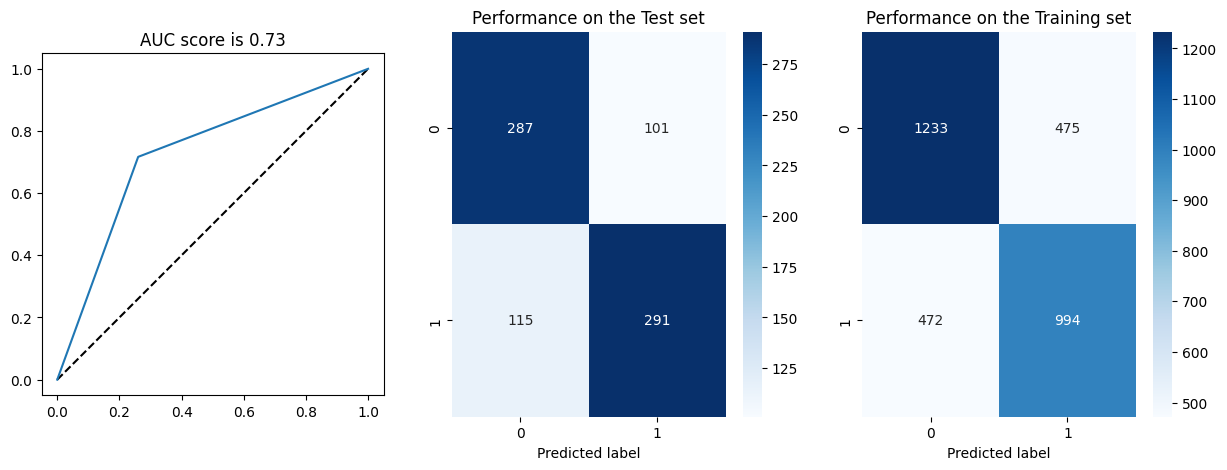

In [44]:
scaler = StandardScaler()

svm_model = svm.SVC()
pipe_svm_std = Pipeline(steps=[("scaler", scaler), ("svm_model", svm_model)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "svm_model__C": (0.5, 1.5, 1, 2, 3)
}
search_svm_std = GridSearchCV(pipe_svm_std, param_grid, cv=3, scoring="f1", refit=True)
search_svm_std.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_svm_std.best_score_)
print(search_svm_std.best_params_)

fpr, tpr, _ = roc_curve(y_test, search_svm_std.best_estimator_.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, search_svm_std.best_estimator_.predict(X_test))))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, search_svm_std.best_estimator_.predict(X_test))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, search_svm_std.best_estimator_.predict(X_train))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')


Best parameter (CV score=0.664):
{'scaler_pol__degree': 1, 'svm_model__degree': 1, 'svm_model__kernel': 'poly'}


Text(0.5, 1.0, 'Performance on the Training set')

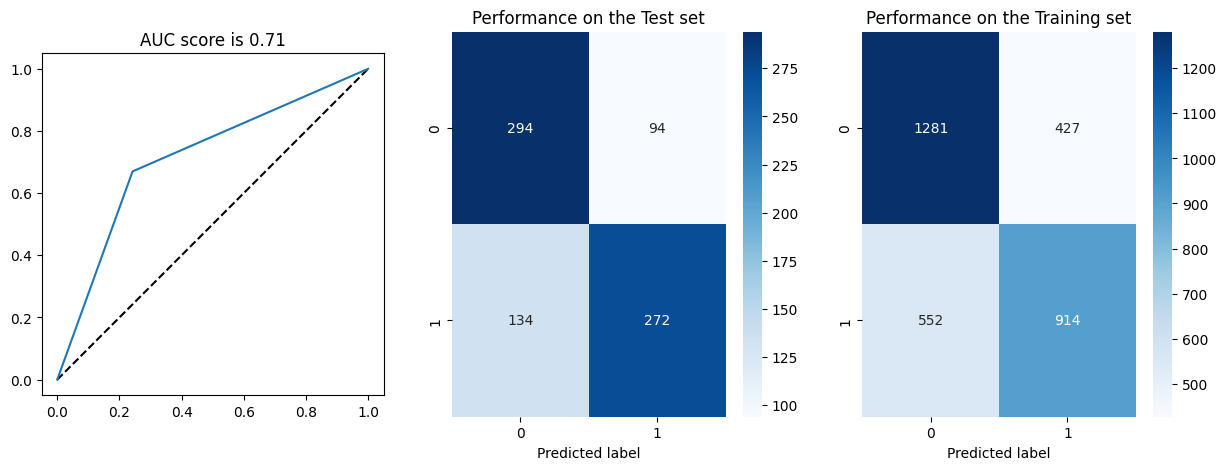

In [43]:
scaler_pol = PolynomialFeatures()

svm_model = svm.SVC()
pipe_svm_pol = Pipeline(steps=[("scaler_pol", scaler_pol), ("svm_model", svm_model)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "svm_model__degree": (1, 2, 3),
    "svm_model__kernel": ("poly",),
    "scaler_pol__degree": (1, 2, 3)
}
search_svm_pol = GridSearchCV(pipe_svm_pol, param_grid, cv=3, scoring="f1", refit=True)
search_svm_pol.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_svm_pol.best_score_)
print(search_svm_pol.best_params_)

fpr, tpr, _ = roc_curve(y_test, search_svm_pol.best_estimator_.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, search_svm_pol.best_estimator_.predict(X_test))))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, search_svm_pol.best_estimator_.predict(X_test))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, search_svm_pol.best_estimator_.predict(X_train))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')


Best parameter (CV score=0.695):
{'logistic__C': 0.001, 'logistic__penalty': 'l2'}


/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/crestr25/Dev/Data-Projects/World Cup/venv

Text(0.5, 1.0, 'Performance on the Training set')

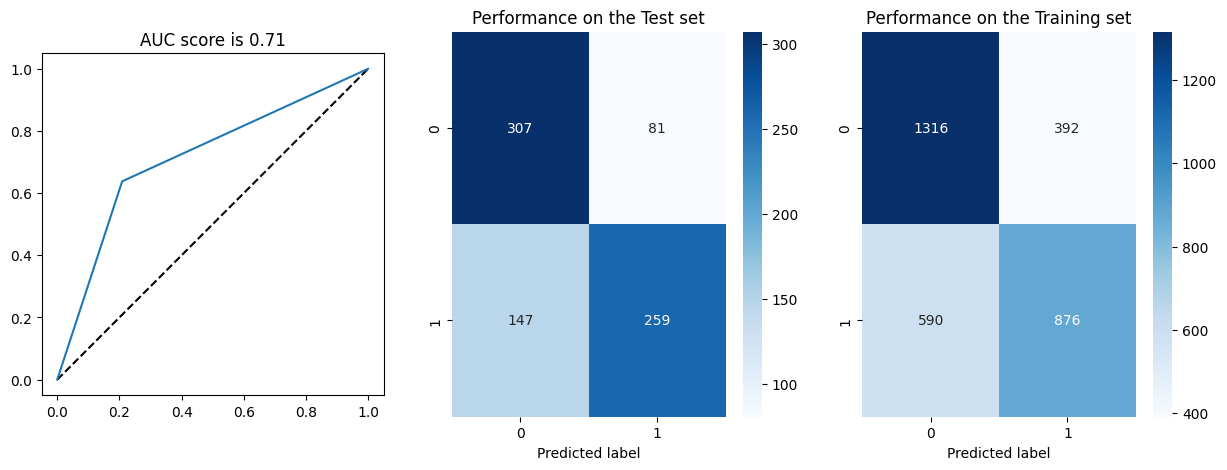

In [45]:
scaler = StandardScaler()

logistic = linear_model.LogisticRegression(max_iter=100000, solver='saga', tol=0.1)
pipe_rg_std = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "logistic__penalty": ('l2', 'l1', 'elasticnet'),
    'logistic__C': (1e-5, 1e-4, 1e-3)
}
search_rg_std = GridSearchCV(pipe_rg_std, param_grid, cv=2, refit=True)
search_rg_std.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rg_std.best_score_)
print(search_rg_std.best_params_)

fpr, tpr, _ = roc_curve(y_test, search_rg_std.best_estimator_.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, search_rg_std.best_estimator_.predict(X_test))))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, search_rg_std.best_estimator_.predict(X_test))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, search_rg_std.best_estimator_.predict(X_train))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')

Best parameter (CV score=0.699):
{'logistic__C': 1e-05, 'logistic__penalty': 'l2', 'scaler__degree': 1}


/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/crestr25/Dev/Data-Projects/World Cup/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/crestr25/Dev/Data-Projects/World Cup/ve

Text(0.5, 1.0, 'Performance on the Training set')

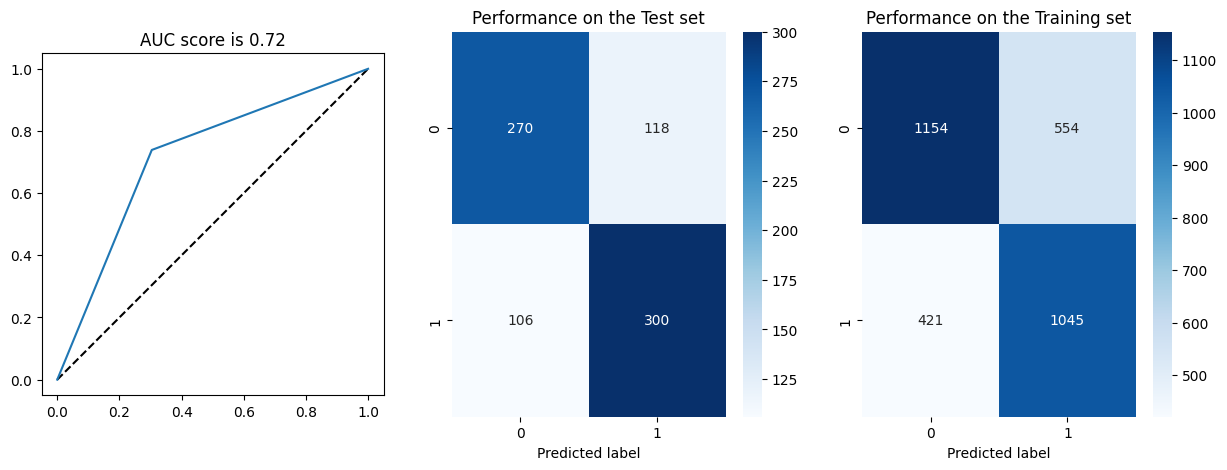

In [46]:

scaler = PolynomialFeatures()

logistic = linear_model.LogisticRegression(max_iter=100000, solver='saga', tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "scaler__degree": (1, 2, 3),
    "logistic__penalty": ('l2', 'l1', 'elasticnet'),
    'logistic__C': (1e-5, 1e-4, 1e-3)
}
search_rg_pol = GridSearchCV(pipe, param_grid, cv=2, refit=True)
search_rg_pol.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rg_pol.best_score_)
print(search_rg_pol.best_params_)

fpr, tpr, _ = roc_curve(y_test, search_rg_pol.best_estimator_.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, search_rg_pol.best_estimator_.predict(X_test))))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, search_rg_pol.best_estimator_.predict(X_test))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, search_rg_pol.best_estimator_.predict(X_train))
sns.heatmap(cm, cmap='Blues', clim = (0, cm.max()), annot=True, fmt="d") 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')

## Predict

In [49]:
while True:
    home_team = input("Home Team: ")
    away_team = input("Away Team: ")

    if home_team in teams_worldcup and away_team in teams_worldcup:
        break
    

predict_df = get_prediction_df(home_team, away_team)
result_rg_log = search_rg_pol.best_estimator_.predict(predict_df)
result_rg_std = search_rg_std.best_estimator_.predict(predict_df)
result_svm_log = search_svm_pol.best_estimator_.predict(predict_df)
result_svm_std = search_svm_std.best_estimator_.predict(predict_df)


winner_rg_log = home_team if result_rg_log else away_team
winner_rg_std = home_team if result_rg_std else away_team
winner_svm_log = home_team if result_svm_log else away_team
winner_svm_std = home_team if result_svm_std else away_team

print(f"linear regression log -> {home_team} VS. {away_team} winner is: {winner_rg_log} -- {result_rg_log}")
print(f"linear regression std -> {home_team} VS. {away_team} winner is: {winner_rg_std} -- {result_rg_std}")

print(f"SVM log-> {home_team} VS. {away_team} winner is: {winner_svm_log} -- {result_svm_log}")
print(f"SVM std -> {home_team} VS. {away_team} winner is: {winner_svm_std} -- {result_svm_std}")

linear regression log -> Ecuador VS. Brazil winner is: Brazil -- [0]
linear regression std -> Ecuador VS. Brazil winner is: Brazil -- [0]
SVM log-> Ecuador VS. Brazil winner is: Brazil -- [0]
SVM std -> Ecuador VS. Brazil winner is: Brazil -- [0]
